In [1]:
!pip install biopython

In [2]:
### Import **Libraries**

import os
import os.path
import numpy as np
import subprocess
import math
import time
import pdb
import shutil
import networkx as nx
import pytraj as pt
import nglview as nv
from pyvis.network import Network
import matplotlib.pyplot as plt
import sys
# sys.setrecursionlimit(100000)

_ColormakerRegistry()

In [3]:
from collections import Counter
from Bio.PDB import MMCIFParser, PDBParser, Selection, NeighborSearch

def pdb_model(structure_file, water=False):
    """Return a biopython [1] model entity from a structure file.

    Parameters
    ----------
    structure_file: string
        Path to structure file
    water: boolean (default=False)
        True to take into account waker molecules in the structure, False
        otherwise.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    accepted_formats = ['cif', 'pdb', 'ent']
    parsers = [MMCIFParser, PDBParser, PDBParser]
    protein_name, file_format = structure_file.rsplit('.', 1)

    try:
        parser = parsers[accepted_formats.index(file_format)]
        parser = parser(QUIET=True)
    except ValueError:
        raise Exception("Accepted structure files are: {}".format(
            accepted_formats))

    structure = parser.get_structure(protein_name, structure_file)
    model = structure[0]

    if not water:
        for chain in model.get_chains():
            for residue in list(chain):
                hetero_flag = residue.id[0].strip()
                # Empty strings evaluate to False.  Therefore hetero_flag
                # returns False if the residue is not a water molecule.
                if hetero_flag:
                    chain.detach_child(residue.id)
            if not list(chain):
                model.detach_child(chain.id)

    return model


def label_residue(residue):
    """ Return a string of the label of the biopython [1] residue object.

    The label of the residue is the following:
        Chain + Position

    Parameters
    ----------
    residue: Bio.PDB.Residue.Residue
        The residue to be labeled.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    position = str(residue.id[1])
    chain = residue.parent.id

    return chain + ' ' + position #added space deliminater for split function.

## Residue adjecmatrixtest

In [4]:
#Biopython used to create adjecency dictionary
def residue_adjacency_CO_test(model, cutoff=5, weight=True):
    """Return residue adjacency dictionary defined by cutoff distance.

    Parameters
    ----------
    model: Bio.PDB.Model
        Model created with the atomic coordinates of the protein file.

    cutoff: int or float
        Distance cutoff defining links between atoms.  Two atoms are adjacent
        if their distance is less than the given cutoff.

    See Also
    --------`````````````
    pdb_model

    """
    #Use only the Atoms specified in paper
    atom_list = Selection.unfold_entities(model, 'A')
    atoms = [atom for atom in atom_list if 'O' in atom.name or 'C' in atom.name] # or 'C' in atom.name
    #Only looking at oxygen for cliques at the momement, for maximum clique finidng in the residue filteration setup
#     print(atoms)

    neighbor_search = NeighborSearch(atoms)
    atomic_adjacency = {}

    for atom in atoms:
        _res = label_residue(atom.get_parent())
        adjacent_atoms = []
        for adj_atom in neighbor_search.search(atom.coord, cutoff):
            _adj_res = label_residue(adj_atom.parent)
            # Adjacent atoms must be in different residues
            if _adj_res != _res:
                adjacent_atoms.append(adj_atom)
        atomic_adjacency[atom] = adjacent_atoms

    adjacency = {}

    # Create residue adjacency dictionary with string format, see
    # label_residue.
    for atom, neighbors in atomic_adjacency.items():
        residue = label_residue(atom.get_parent())
        adjacency.setdefault(residue, [])

        # Only different residues are connected by an edge (No loops).
        not_in_residue = []
        for neighbor in neighbors:
            neighbor_parent = label_residue(neighbor.get_parent())
            if neighbor_parent is not residue:
                not_in_residue.append(neighbor_parent)

        adjacency[residue].extend(not_in_residue)

    if not weight:

        return adjacency

    # Make new dictionary mapping each residue to its neighbors taking
    # into account the weight.
    weighted_adjacency = {}
    for residue in adjacency:
        counter = Counter(adjacency[residue])
        weighted_adjacency[residue] = {
            neighbor: {'weight': counter[neighbor]}
            for neighbor in counter}

    return weighted_adjacency

In [5]:

def topo_network(model, cutoff=4, weight=True):
    """Return the interaction network of a protein structure.

    The interaction network is defined by a distance cutoff.

    Parameters
    ----------
    model: Bio.PDB.model
        The protein structure.
    cutoff: float
        The distance cutoff defining an interaction between two nodes.
    weight: boolean
        True if atomic interactions are to be considered.
    """

    adjacency_dictionary = residue_adjacency_CO_test(model, cutoff=cutoff,
                                            weight=weight)

    return nx.Graph(adjacency_dictionary)


In [6]:
class Pmolecule(object):
    """Create a Pmolecule object.

    The Pmolecule calls a number of methods for the analysis of protein
    structure. This includes the construction of the interaction network of the
    protein.

    Parameters
    ----------
    structure_file = str
        The path to the structure file of the targeted protein. Three
        structure-file formats are accepted: `pdb', `cif', and `ent'.
    water: boolean, default is False
        If false, water molecules are ignored.

    Attributes
    ----------
    model: Bio.PDB.model
        The structural model of the structure. See www.biopython.org.
    path_to_file: str
        The path to the structural file used to instantiate the class.
    """

    def __init__(self, structure_file, water=False):
        self.model = pdb_model(structure_file, water=water)
        self.path_to_file = structure_file

    def get_network(self, cutoff=5, weight=True):
        """Return the interaction network of a protein structure.

        The interaction network is defined by a distance cutoff.

        Parameters
        ----------
        model: Bio.PDB.model
            The protein structure.
        cutoff: float
            The distance cutoff defining an interaction between two nodes.
        weight: boolean
            True if atomic interactions are to be considered.
        """

        return topo_network(self.model, cutoff=cutoff, weight=weight)

    def get_pdbmodel(self):
        return self.model

In [7]:
########################################################################################################

In [8]:
class FileOperation(object):
    """ generated source for class FileOperation """

    @classmethod
    def getEntriesAsList(cls, fileName):
        """ generated source for method getEntriesAsList """
        #  Return list entries. 
        #  An element of that list is one line of the file fileName.
        fil = open(fileName, "r")
        entries = fil.read().split('\n')
        fil.close()
        return entries

    @classmethod
    def saveResults(cls, entryNames, fileName, option):
        """ generated source for method saveResults """
        #  Write list entryNames in file fileName.
        #  An element in entryNames is one line in fileName.
        if option == "w":
            try:
                with open(fileName, "w") as f:
                    i = 0
                    while i < len(entryNames):
                        f.write(str(entryNames[i]) + "\n")
                        i += 1
            except Exception as e:
                pass

In [9]:
class ParsePDB(object):
    """ generated source for class ParsePDB """
    @classmethod
    def getLines(cls, PDBFile, field, subfield, atom):
        """ generated source for method getLines """
        #  Return a list, the element of which is a line in the file with name PDBFile
        #  that contains the specified atom in a specified field.
        returnList = []
        fileList = []
        line = ""
        i = 0
        if atom != "allatom":
            if (0 == len(atom)) or (len(atom) >= 4):
                print("error! in getLines")
        fileList = FileOperation.getEntriesAsList(PDBFile)
        while i < len(fileList):
            line = str(fileList[i])
            if field == "HETATM" and subfield != "HOH" and line.startswith(field) and line[17:20].strip() in atom:
                returnList.append(line)
            if field == "ATOM" and subfield == "Res" and line.startswith(field) and line[13:17].startswith(atom):
                returnList.append(line)
            if field == "HETATM" and subfield == "HOH" and line.startswith(field) and line[12: 14].startswith(atom) and line[17: 20].startswith(subfield):
                returnList.append(line)
            if subfield == "HET":
                if field == "HETATM" and subfield != "HOH" and line.startswith(field) and line[12:14].startswith(atom) and ("HOH" in line[17: 20]) == False:
                    returnList.append(line)
            if field == "ATOM" and subfield == "ResNoWater" and (line.startswith("ATOM") or line.startswith("HETATM")) and atom == "allatom":
                if ("HOH" in line[17:20]) == False:
                    returnList.append(line)
            if field == "ATOM" and subfield == "Res" and (line.startswith("ATOM") or line.startswith("HETATM")) and atom == "allatom":
                returnList.append(line)
            i += 1
        return returnList

    @classmethod
    def getBondedLines(cls, PDBFile, atom, bondedAtom):
        """ generated source for method getBondedLines """
        returnList = []
        carbonList = []
        oxygenList = []
        fileList = []
        line = ""
        i = 0
        if 0 == len(atom) or len(atom) > 1 or 0 == len(bondedAtom) or len(bondedAtom) > 1:
            print("error! in getBondedLines")
        atom = atom.upper()
        bondedAtom = bondedAtom.upper()
        temp = ""
        fileList = FileOperation.getEntriesAsList(PDBFile)
        while i < len(fileList):
            line = str(fileList[i])
            if ("ATOM" in line[0:4]) and (bondedAtom in line[13]):
                carbonList.append(line)
                if temp == "" and (len(oxygenList)==0) == False:
                    k = 0
                    while k < len(oxygenList):
                        returnList.append(str(oxygenList[k]))
                        k += 1
                # print(oxygenList)
                # oxygenList = []
                temp = line[13:14]
            if ("ATOM" in line[0:4]) and (atom in line[13]):
                oxygenList.append(line)
                if temp == "C" and ((len(carbonList)==0) == False):
                    k = 0
                    while k < len(carbonList):
                        returnList.append(str(carbonList[k]))
                        k += 1
                # print(carbonList)
                # carbonList = []
                temp = line[13:14]
            if (("TER" in line[0:4]) or ("HETATM" in line[0:6]) and (0 != len(temp))):
                k = 0
                while k < len(oxygenList):
                    returnList.append(str(oxygenList[k]))
                    k += 1
                # print(oxygenList)
                # oxygenList = []
                temp = ""
            i += 1
        return returnList

In [10]:
def runPrediction(filenamearg, metal, PDBID, resultAtoms):
    """ generated source for method getMetal """
    fileList = []
    resultList = []
    allAtom = []
    allAtomNoWater = []
    currDirectory = os.getcwd()
    fileList = FileOperation.getEntriesAsList(filenamearg)
    #  a list of PDBIDs   
    # print(args);
    fileName = currDirectory + "/inputdata/" + PDBID + ".pdb"
    caList = ParsePDB.getLines(fileName, "HETATM", metal, metal)
    # print("This is the caList", caList)
    allAtom = ParsePDB.getLines(fileName, "ATOM", "Res", "allatom")
    pdb_site_list = allAtom + resultAtoms
    FileOperation.saveResults(pdb_site_list, currDirectory + "/predictionResults/" + PDBID + "_site.pdb", "w")
    print("File: " + currDirectory + "/predictionResults/" + PDBID + "_site.pdb" + " just written")
    print('Completed!')
    resultList = []


In [11]:
from Bio.PDB import Entity

def center_of_mass(entity, geometric=False):
    """
    Returns gravitic [default] or geometric center of mass of an Entity.
    Geometric assumes all masses are equal (geometric=True)
    """
    
    # Structure, Model, Chain, Residue
    if isinstance(entity, Entity.Entity):
        atom_list = entity.get_atoms()
    # List of Atoms
    elif hasattr(entity, '__iter__') and [x for x in entity if x.level == 'A']:
        atom_list = entity
    else: # Some other weirdo object
        raise ValueError("Center of Mass can only be calculated from the following objects:\n"
                            "Structure, Model, Chain, Residue, list of Atoms.")
    
    masses = []
    positions = [ [], [], [] ] # [ [X1, X2, ..] , [Y1, Y2, ...] , [Z1, Z2, ...] ]
    
    for atom in atom_list:
        masses.append(atom.mass)
        
        for i, coord in enumerate(atom.coord.tolist()):
            positions[i].append(coord)

    # If there is a single atom with undefined mass complain loudly.
    if 'ukn' in set(masses) and not geometric:
        raise ValueError("Some Atoms don't have an element assigned.\n"
                         "Try adding them manually or calculate the geometrical center of mass instead.")
    
    if geometric:
        return [sum(coord_list)/len(masses) for coord_list in positions]
    else:       
        w_pos = [ [], [], [] ]
        for atom_index, atom_mass in enumerate(masses):
            w_pos[0].append(positions[0][atom_index]*atom_mass)
            w_pos[1].append(positions[1][atom_index]*atom_mass)
            w_pos[2].append(positions[2][atom_index]*atom_mass)

        return [sum(coord_list)/sum(masses) for coord_list in w_pos]

In [12]:
# def get_Metal():
#     meList = ParsePDB.getLines(fileName, "HETATM", metal, metal)

## Experimental

In [13]:
PDBID = '3cln'
metal = 'CA'

In [14]:
def setup(arg):
    pdb_id = arg
    commands = 'mkdir -p ./inputdata; mkdir -p ./predictionResults; cd inputdata; wget https://files.rcsb.org/download/'+ pdb_id + '.pdb; echo "'+ pdb_id + '" >> list.txt; cat list.txt; cd .. echo "Created all needed folders";'
    p = subprocess.Popen(commands, shell=True, stdout=subprocess.PIPE)
    p.wait()
  # print(str(p.communicate()[0], 'utf-8'))

setup(PDBID)

In [15]:
fileName = './inputdata/'+ PDBID + '.pdb'
caListtest = ParsePDB.getLines(fileName, "HETATM", metal, metal)
caListtest

['HETATM 1128 CA    CA A 149     -13.638  53.352  31.500  1.00 12.29          CA  ',
 'HETATM 1129 CA    CA A 150     -17.797  50.156  20.859  1.00 15.64          CA  ',
 'HETATM 1130 CA    CA A 151      15.035  17.711  17.954  1.00 28.17          CA  ',
 'HETATM 1131 CA    CA A 152      13.784  23.887   8.345  1.00 29.20          CA  ']

In [16]:
import re
from numpy import array

def vecCaList(caListtest):
    fList = []
    for caitem in caListtest:
        txt=caitem
        re1='.*?'	# Non-greedy match on filler
        re2='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 1
        re3='.*?'	# Non-greedy match on filler
        re4='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 2
        re5='.*?'	# Non-greedy match on filler
        re6='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 3
        rg = re.compile(re1+re2+re3+re4+re5+re6,re.IGNORECASE|re.DOTALL)
        m = rg.search(txt)
        if m:
            float1=m.group(1)
            float2=m.group(2)
            float3=m.group(3)
            print ("("+float1+")"+"("+float2+")"+"("+float3+")"+"\n")
        plhld = [float(float1), float(float2), float(float3)]
        ac = array(plhld)
        fList.append(ac)
    return fList

In [17]:
caList = vecCaList(caListtest)

(-13.638)(53.352)(31.500)

(-17.797)(50.156)(20.859)

(15.035)(17.711)(17.954)

(13.784)(23.887)(8.345)



In [18]:
caList

[array([-13.638,  53.352,  31.5  ]),
 array([-17.797,  50.156,  20.859]),
 array([15.035, 17.711, 17.954]),
 array([13.784, 23.887,  8.345])]

In [19]:
molecule = Pmolecule('./inputdata/'+ PDBID + '.pdb')

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


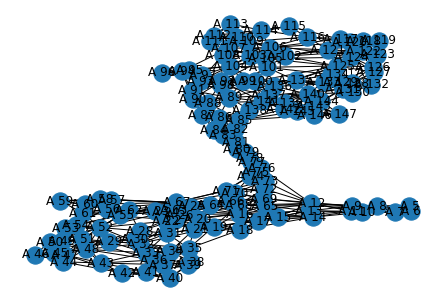

In [20]:
# Create Biograph, uses Biopython for stucture and networkx for drawing the graphs
Graph = molecule.get_network()
nx.draw(Graph, with_labels = True) #, with_labels = True

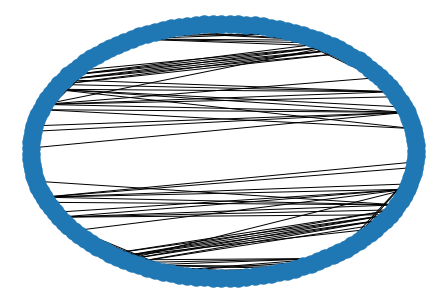

In [21]:
nx.draw_circular(Graph)

In [22]:
model = molecule.get_pdbmodel()

In [23]:
adjmatrix = residue_adjacency_CO_test(model, cutoff=4, weight=True)

In [24]:
# adjmatrix

In [25]:
def get_res_cliqs(G, M):
    # Find max cliques
    renamed_cliques=[]
    cliques=[clique for clique in nx.find_cliques(G) if len(clique)>= 4]
    for cliq in cliques:
        c=[]
        for cli in cliq:
            res = M[str(cli.split(' ')[0])][int(cli.split(' ')[1])]
            if (res.get_resname() == 'ASP') or (res.get_resname() == 'GLU') or (res.get_resname() == 'ASN') or (res.get_resname() == 'GLN') or (res.get_resname() == 'SER') or (res.get_resname() == 'THR'):
                c.append(res)
            else:
                continue
        renamed_cliques.append(c)
    print('Number of cliques found: ',len(cliques))
    return(renamed_cliques)

In [26]:
reslist = get_res_cliqs(Graph, model)

Number of cliques found:  208


In [27]:
reslist

[[<Residue GLU het=  resseq=47 icode= >,
  <Residue ASN het=  resseq=42 icode= >,
  <Residue THR het=  resseq=44 icode= >],
 [<Residue GLU het=  resseq=47 icode= >,
  <Residue THR het=  resseq=44 icode= >,
  <Residue GLU het=  resseq=45 icode= >],
 [<Residue GLU het=  resseq=47 icode= >,
  <Residue THR het=  resseq=44 icode= >],
 [<Residue GLU het=  resseq=47 icode= >,
  <Residue GLN het=  resseq=49 icode= >,
  <Residue ASP het=  resseq=50 icode= >],
 [<Residue GLU het=  resseq=47 icode= >,
  <Residue GLN het=  resseq=49 icode= >,
  <Residue GLU het=  resseq=45 icode= >],
 [<Residue GLU het=  resseq=47 icode= >,
  <Residue GLN het=  resseq=49 icode= >,
  <Residue ASP het=  resseq=50 icode= >],
 [<Residue GLU het=  resseq=47 icode= >],
 [<Residue GLN het=  resseq=143 icode= >],
 [<Residue GLN het=  resseq=143 icode= >,
  <Residue THR het=  resseq=146 icode= >],
 [<Residue GLN het=  resseq=143 icode= >,
  <Residue GLU het=  resseq=140 icode= >],
 [<Residue GLU het=  resseq=87 icode= >],


## Maximal Cliques, Carbon Clusters

In [28]:
def centreCa2(resatoms):
    ans = []
    for i, (atomlist) in enumerate(resatoms):
        if not atomlist:
            continue
        elif len(atomlist) > 2:
            ans.append(center_of_mass(atomlist))
    return ans

In [29]:
#Given a group of residues, for each atom in the residue return the one with the min(dist) from the any of the HETAM CA
def positionDistFilter(reslist, caList, model):
    # First get oxygen in each residue
    limit = 1.74
    cutoff = 2.5
    resoxygrouped = []
    for resli in reslist:
        grup = []
        for res in resli:
            atom_list = res.get_list()
            resatoms = [atom for atom in atom_list if 'O' in atom.name]
            print(resatoms)
            for acvec in caList:
                alpha_carbon = acvec
                distances = []
                resoxygroup = []
                for i,(atom) in enumerate(resatoms):
                    #subtract the two position vectors
                    print(atom.get_coord())
                    diff_vector = alpha_carbon - atom.get_coord()
                    #to get a positive value we square the difference vector
                    #we then take the square root to go back to the original scale
                    distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    dist = np.sqrt(np.sum(diff_vector * diff_vector))
                    print(i)
                    print('The distances are: ',distances)
                    #we get the nearest atom using min(distances) or dist and see if it falls inside
                    #the cutoff
                    if (0 < dist) and (dist > limit) and (dist < cutoff):
                        grup.append(atom)
                    print(res)
        resoxygrouped.append(grup)
    return resoxygrouped
#finding Ca binding site from remaining max clique residue


In [30]:
positionDistFilterans = positionDistFilter(reslist, caList, model)

[<Atom O>, <Atom OE1>, <Atom OE2>]
[-2.687 50.262 19.117]
0
The distances are:  [16.816990468979853]
<Residue GLU het=  resseq=47 icode= >
[ 3.319 51.588 19.981]
1
The distances are:  [16.816990468979853, 20.575200631813196]
<Residue GLU het=  resseq=47 icode= >
[ 3.64  50.271 18.285]
2
The distances are:  [16.816990468979853, 20.575200631813196, 21.96948060883813]
<Residue GLU het=  resseq=47 icode= >
[-2.687 50.262 19.117]
0
The distances are:  [15.210453546974499]
<Residue GLU het=  resseq=47 icode= >
[ 3.319 51.588 19.981]
1
The distances are:  [15.210453546974499, 21.1827044128997]
<Residue GLU het=  resseq=47 icode= >
[ 3.64  50.271 18.285]
2
The distances are:  [15.210453546974499, 21.1827044128997, 21.59128702190138]
<Residue GLU het=  resseq=47 icode= >
[-2.687 50.262 19.117]
0
The distances are:  [37.0808511793197]
<Residue GLU het=  resseq=47 icode= >
[ 3.319 51.588 19.981]
1
The distances are:  [37.0808511793197, 35.90298876543316]
<Residue GLU het=  resseq=47 icode= >
[ 3.

[-7.354 51.615 17.513]
0
The distances are:  [11.062578619744162]
<Residue GLN het=  resseq=49 icode= >
[-9.515 54.615 17.918]
1
The distances are:  [11.062578619744162, 9.855135696167647]
<Residue GLN het=  resseq=49 icode= >
[-7.354 51.615 17.513]
0
The distances are:  [40.63179955997967]
<Residue GLN het=  resseq=49 icode= >
[-9.515 54.615 17.918]
1
The distances are:  [40.63179955997967, 44.323911749688364]
<Residue GLN het=  resseq=49 icode= >
[-7.354 51.615 17.513]
0
The distances are:  [36.05148204865739]
<Residue GLN het=  resseq=49 icode= >
[-9.515 54.615 17.918]
1
The distances are:  [36.05148204865739, 39.73280532667009]
<Residue GLN het=  resseq=49 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[-6.612 48.189 16.792]
0
The distances are:  [17.098143848248714]
<Residue ASP het=  resseq=50 icode= >
[-4.473 51.051 13.632]
1
The distances are:  [17.098143848248714, 20.212799316783787]
<Residue ASP het=  resseq=50 icode= >
[-2.435 50.78  14.324]
2
The distances are:  [17.0981438482

[ 1.992 29.041 18.344]
1
The distances are:  [32.77898297427746, 31.755345098119992]
<Residue GLU het=  resseq=82 icode= >
[ 0.031 28.483 17.507]
2
The distances are:  [32.77898297427746, 31.755345098119992, 31.6403663333163]
<Residue GLU het=  resseq=82 icode= >
[ 0.077 25.698 20.472]
0
The distances are:  [30.295600524330247]
<Residue GLU het=  resseq=82 icode= >
[ 1.992 29.041 18.344]
1
The distances are:  [30.295600524330247, 29.047770234288567]
<Residue GLU het=  resseq=82 icode= >
[ 0.031 28.483 17.507]
2
The distances are:  [30.295600524330247, 29.047770234288567, 28.262916087778738]
<Residue GLU het=  resseq=82 icode= >
[ 0.077 25.698 20.472]
0
The distances are:  [17.142761063959224]
<Residue GLU het=  resseq=82 icode= >
[ 1.992 29.041 18.344]
1
The distances are:  [17.142761063959224, 17.281228475260132]
<Residue GLU het=  resseq=82 icode= >
[ 0.031 28.483 17.507]
2
The distances are:  [17.142761063959224, 17.281228475260132, 18.475816755124157]
<Residue GLU het=  resseq=82 i

2
The distances are:  [21.353999156024923, 23.093023602182825, 24.029112268342914]
<Residue GLU het=  resseq=114 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[ 5.992  4.19  11.048]
0
The distances are:  [56.749655793549174]
<Residue GLU het=  resseq=114 icode= >
[2.243 3.901 7.537]
1
The distances are:  [56.749655793549174, 57.19993812158298]
<Residue GLU het=  resseq=114 icode= >
[0.266 4.022 8.554]
2
The distances are:  [56.749655793549174, 57.19993812158298, 56.154154368203166]
<Residue GLU het=  resseq=114 icode= >
[ 5.992  4.19  11.048]
0
The distances are:  [52.678699595310974]
<Residue GLU het=  resseq=114 icode= >
[2.243 3.901 7.537]
1
The distances are:  [52.678699595310974, 52.140217714627305]
<Residue GLU het=  resseq=114 icode= >
[0.266 4.022 8.554]
2
The distances are:  [52.678699595310974, 52.140217714627305, 51.04929938471751]
<Residue GLU het=  resseq=114 icode= >
[ 5.992  4.19  11.048]
0
The distances are:  [17.67161899638081]
<Residue GLU het=  resseq=114 icode= >
[2.2

[-4.843 29.652 19.482]
0
The distances are:  [27.99061130904001]
<Residue ASP het=  resseq=78 icode= >
[-8.485 32.304 16.622]
1
The distances are:  [27.99061130904001, 26.285482158147126]
<Residue ASP het=  resseq=78 icode= >
[-9.312 30.591 17.738]
2
The distances are:  [27.99061130904001, 26.285482158147126, 26.947542239404832]
<Residue ASP het=  resseq=78 icode= >
[-4.843 29.652 19.482]
0
The distances are:  [24.29230833397889]
<Residue ASP het=  resseq=78 icode= >
[-8.485 32.304 16.622]
1
The distances are:  [24.29230833397889, 20.57569913960168]
<Residue ASP het=  resseq=78 icode= >
[-9.312 30.591 17.738]
2
The distances are:  [24.29230833397889, 20.57569913960168, 21.55284427712622]
<Residue ASP het=  resseq=78 icode= >
[-4.843 29.652 19.482]
0
The distances are:  [23.239129882545743]
<Residue ASP het=  resseq=78 icode= >
[-8.485 32.304 16.622]
1
The distances are:  [23.239129882545743, 27.711374604669967]
<Residue ASP het=  resseq=78 icode= >
[-9.312 30.591 17.738]
2
The distance

1
The distances are:  [4.667619876306689, 3.9894993886675074]
<Residue ASP het=  resseq=93 icode= >
[13.313 18.284 19.079]
2
The distances are:  [4.667619876306689, 3.9894993886675074, 2.135237800544643]
<Residue ASP het=  resseq=93 icode= >
[12.063 17.019 21.486]
0
The distances are:  [14.927061362357604]
<Residue ASP het=  resseq=93 icode= >
[12.724 20.092 20.169]
1
The distances are:  [14.927061362357604, 12.463250901086713]
<Residue ASP het=  resseq=93 icode= >
[13.313 18.284 19.079]
2
The distances are:  [14.927061362357604, 12.463250901086713, 12.117516740976054]
<Residue ASP het=  resseq=93 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[16.595 18.314 22.554]
0
The distances are:  [47.13519544813159]
<Residue ASP het=  resseq=95 icode= >
[18.141 16.471 19.302]
1
The distances are:  [47.13519544813159, 50.188686004731196]
<Residue ASP het=  resseq=95 icode= >
[16.327 17.598 19.757]
2
The distances are:  [47.13519544813159, 50.188686004731196, 48.10559012370752]
<Residue ASP het=  re

[-19.3    46.488  24.165]
2
The distances are:  [6.647144747989269, 5.012880552608857, 5.161674183042715]
<Residue ASP het=  resseq=64 icode= >
[-17.2    45.584  25.647]
0
The distances are:  [43.30336732762823]
<Residue ASP het=  resseq=64 icode= >
[-21.     47.883  23.974]
1
The distances are:  [43.30336732762823, 47.38260424688753]
<Residue ASP het=  resseq=64 icode= >
[-19.3    46.488  24.165]
2
The distances are:  [43.30336732762823, 47.38260424688753, 45.228136975379996]
<Residue ASP het=  resseq=64 icode= >
[-17.2    45.584  25.647]
0
The distances are:  [41.59479869178164]
<Residue ASP het=  resseq=64 icode= >
[-21.     47.883  23.974]
1
The distances are:  [41.59479869178164, 45.05552479182904]
<Residue ASP het=  resseq=64 icode= >
[-19.3    46.488  24.165]
2
The distances are:  [41.59479869178164, 45.05552479182904, 43.07700765586696]
<Residue ASP het=  resseq=64 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[-12.567  50.29   35.225]
0
The distances are:  [4.9394829883365]
<Res

[-18.106  52.599  20.835]
1
The distances are:  [5.982538667169461, 2.462580319264635]
<Residue ASN het=  resseq=60 icode= >
[-16.743  55.983  20.007]
0
The distances are:  [49.78757083476531]
<Residue ASN het=  resseq=60 icode= >
[-18.106  52.599  20.835]
1
The distances are:  [49.78757083476531, 48.205793969767875]
<Residue ASN het=  resseq=60 icode= >
[-16.743  55.983  20.007]
0
The distances are:  [45.804511784916514]
<Residue ASN het=  resseq=60 icode= >
[-18.106  52.599  20.835]
1
The distances are:  [45.804511784916514, 44.69173438647389]
<Residue ASN het=  resseq=60 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[-15.539  48.132  16.313]
0
The distances are:  [16.17118353673189]
<Residue ASP het=  resseq=56 icode= >
[-15.07   51.68   18.103]
1
The distances are:  [16.17118353673189, 13.5766637261892]
<Residue ASP het=  resseq=56 icode= >
[-16.348  50.152  19.195]
2
The distances are:  [16.17118353673189, 13.5766637261892, 12.99988951723543]
<Residue ASP het=  resseq=56 icode= >
[-

[16.238 10.963  3.996]
2
The distances are:  [10.656709531323267, 11.67040250652246, 13.85516831835061]
<Residue ASP het=  resseq=122 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[ 8.807 15.229  2.003]
0
The distances are:  [53.17155406769564]
<Residue GLU het=  resseq=123 icode= >
[ 6.719 11.946 -1.511]
1
The distances are:  [53.17155406769564, 56.73262196171518]
<Residue GLU het=  resseq=123 icode= >
[ 8.515 10.817 -0.98 ]
2
The distances are:  [53.17155406769564, 56.73262196171518, 57.92177498445303]
<Residue GLU het=  resseq=123 icode= >
[ 8.807 15.229  2.003]
0
The distances are:  [47.78301876543891]
<Residue GLU het=  resseq=123 icode= >
[ 6.719 11.946 -1.511]
1
The distances are:  [47.78301876543891, 50.61082140561452]
<Residue GLU het=  resseq=123 icode= >
[ 8.515 10.817 -0.98 ]
2
The distances are:  [47.78301876543891, 50.61082140561452, 52.12312513929463]
<Residue GLU het=  resseq=123 icode= >
[ 8.807 15.229  2.003]
0
The distances are:  [17.302679153256445]
<Residue GLU het= 

<Residue ASP het=  resseq=122 icode= >
[12.221 14.641  3.282]
0
The distances are:  [15.251592734877288]
<Residue ASP het=  resseq=122 icode= >
[15.713 12.936  4.802]
1
The distances are:  [15.251592734877288, 14.008405099725081]
<Residue ASP het=  resseq=122 icode= >
[16.238 10.963  3.996]
2
The distances are:  [15.251592734877288, 14.008405099725081, 15.550192077247985]
<Residue ASP het=  resseq=122 icode= >
[12.221 14.641  3.282]
0
The distances are:  [10.656709531323267]
<Residue ASP het=  resseq=122 icode= >
[15.713 12.936  4.802]
1
The distances are:  [10.656709531323267, 11.67040250652246]
<Residue ASP het=  resseq=122 icode= >
[16.238 10.963  3.996]
2
The distances are:  [10.656709531323267, 11.67040250652246, 13.85516831835061]
<Residue ASP het=  resseq=122 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[14.156  9.029  4.717]
0
The distances are:  [58.77383632366963]
<Residue ASP het=  resseq=118 icode= >
[17.645  8.602  5.075]
1
The distances are:  [58.77383632366963, 60.6586286

The distances are:  [21.242129345947607]
<Residue GLU het=  resseq=6 icode= >
[-25.933  33.803  38.324]
1
The distances are:  [21.242129345947607, 24.081058508846066]
<Residue GLU het=  resseq=6 icode= >
[-26.589  31.865  37.662]
2
The distances are:  [21.242129345947607, 24.081058508846066, 25.83388911094594]
<Residue GLU het=  resseq=6 icode= >
[-21.498  34.011  35.421]
0
The distances are:  [22.054710484287725]
<Residue GLU het=  resseq=6 icode= >
[-25.933  33.803  38.324]
1
The distances are:  [22.054710484287725, 25.27135412103801]
<Residue GLU het=  resseq=6 icode= >
[-26.589  31.865  37.662]
2
The distances are:  [22.054710484287725, 25.27135412103801, 26.34768932310231]
<Residue GLU het=  resseq=6 icode= >
[-21.498  34.011  35.421]
0
The distances are:  [43.65141716772233]
<Residue GLU het=  resseq=6 icode= >
[-25.933  33.803  38.324]
1
The distances are:  [43.65141716772233, 48.50017044197388]
<Residue GLU het=  resseq=6 icode= >
[-26.589  31.865  37.662]
2
The distances are: 

The distances are:  [58.77383632366963, 60.65862866528573]
<Residue ASP het=  resseq=118 icode= >
[16.22   9.134  6.672]
2
The distances are:  [58.77383632366963, 60.65862866528573, 58.848629974913486]
<Residue ASP het=  resseq=118 icode= >
[14.156  9.029  4.717]
0
The distances are:  [54.52511794861669]
<Residue ASP het=  resseq=118 icode= >
[17.645  8.602  5.075]
1
The distances are:  [54.52511794861669, 56.850725191621464]
<Residue ASP het=  resseq=118 icode= >
[16.22   9.134  6.672]
2
The distances are:  [54.52511794861669, 56.850725191621464, 55.14736359636612]
<Residue ASP het=  resseq=118 icode= >
[14.156  9.029  4.717]
0
The distances are:  [15.854586990992642]
<Residue ASP het=  resseq=118 icode= >
[17.645  8.602  5.075]
1
The distances are:  [15.854586990992642, 15.989203388340323]
<Residue ASP het=  resseq=118 icode= >
[16.22   9.134  6.672]
2
The distances are:  [15.854586990992642, 15.989203388340323, 14.221556909569154]
<Residue ASP het=  resseq=118 icode= >
[14.156  9.02

The distances are:  [34.457185078993696, 37.31727126047266]
<Residue THR het=  resseq=70 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[-19.558  53.069  31.682]
0
The distances are:  [5.929554726753888]
<Residue ASP het=  resseq=24 icode= >
[-17.153  55.45   30.305]
1
The distances are:  [5.929554726753888, 4.264370482705535]
<Residue ASP het=  resseq=24 icode= >
[-16.216  53.754  31.404]
2
The distances are:  [5.929554726753888, 4.264370482705535, 2.610920026311087]
<Residue ASP het=  resseq=24 icode= >
[-19.558  53.069  31.682]
0
The distances are:  [11.345660193907943]
<Residue ASP het=  resseq=24 icode= >
[-17.153  55.45   30.305]
1
The distances are:  [11.345660193907943, 10.84749289009267]
<Residue ASP het=  resseq=24 icode= >
[-16.216  53.754  31.404]
2
The distances are:  [11.345660193907943, 10.84749289009267, 11.253541164182542]
<Residue ASP het=  resseq=24 icode= >
[-19.558  53.069  31.682]
0
The distances are:  [51.335385764014596]
<Residue ASP het=  resseq=24 icode= >
[-17.1

2
The distances are:  [41.321508176915124, 47.1702575219315, 45.89476905625344]
<Residue GLU het=  resseq=31 icode= >
[-5.731 51.227 30.32 ]
0
The distances are:  [40.139899097810954]
<Residue GLU het=  resseq=31 icode= >
[-11.595  53.888  32.345]
1
The distances are:  [40.139899097810954, 46.04512724974763]
<Residue GLU het=  resseq=31 icode= >
[-11.533  52.987  30.447]
2
The distances are:  [40.139899097810954, 46.04512724974763, 44.45513340947487]
<Residue GLU het=  resseq=31 icode= >
[<Atom O>, <Atom OD1>, <Atom OD2>]
[-19.558  53.069  31.682]
0
The distances are:  [5.929554726753888]
<Residue ASP het=  resseq=24 icode= >
[-17.153  55.45   30.305]
1
The distances are:  [5.929554726753888, 4.264370482705535]
<Residue ASP het=  resseq=24 icode= >
[-16.216  53.754  31.404]
2
The distances are:  [5.929554726753888, 4.264370482705535, 2.610920026311087]
<Residue ASP het=  resseq=24 icode= >
[-19.558  53.069  31.682]
0
The distances are:  [11.345660193907943]
<Residue ASP het=  resseq=24

[16.264 14.689 14.058]
1
The distances are:  [10.627272854889712, 11.108193636476788]
<Residue SER het=  resseq=101 icode= >
[<Atom O>, <Atom OG>]
[13.267 14.136 12.539]
0
The distances are:  [51.198566919270064]
<Residue SER het=  resseq=101 icode= >
[16.264 14.689 14.058]
1
The distances are:  [51.198566919270064, 51.89586242557327]
<Residue SER het=  resseq=101 icode= >
[13.267 14.136 12.539]
0
The distances are:  [48.28700589984186]
<Residue SER het=  resseq=101 icode= >
[16.264 14.689 14.058]
1
The distances are:  [48.28700589984186, 49.64185132460886]
<Residue SER het=  resseq=101 icode= >
[13.267 14.136 12.539]
0
The distances are:  [6.72522716211277]
<Residue SER het=  resseq=101 icode= >
[16.264 14.689 14.058]
1
The distances are:  [6.72522716211277, 5.081509923037745]
<Residue SER het=  resseq=101 icode= >
[13.267 14.136 12.539]
0
The distances are:  [10.627272854889712]
<Residue SER het=  resseq=101 icode= >
[16.264 14.689 14.058]
1
The distances are:  [10.627272854889712, 1

[12.724 20.092 20.169]
1
The distances are:  [14.927061362357604, 12.463250901086713]
<Residue ASP het=  resseq=93 icode= >
[13.313 18.284 19.079]
2
The distances are:  [14.927061362357604, 12.463250901086713, 12.117516740976054]
<Residue ASP het=  resseq=93 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[10.69  10.994 15.506]
0
The distances are:  [51.39902470527058]
<Residue GLU het=  resseq=104 icode= >
[14.063 15.928 16.839]
1
The distances are:  [51.39902470527058, 48.81440390407834]
<Residue GLU het=  resseq=104 icode= >
[14.887 15.027 18.597]
2
The distances are:  [51.39902470527058, 48.81440390407834, 49.48705515474998]
<Residue GLU het=  resseq=104 icode= >
[10.69  10.994 15.506]
0
The distances are:  [48.7219249279762]
<Residue GLU het=  resseq=104 icode= >
[14.063 15.928 16.839]
1
The distances are:  [48.7219249279762, 46.93373978324205]
<Residue GLU het=  resseq=104 icode= >
[14.887 15.027 18.597]
2
The distances are:  [48.7219249279762, 46.93373978324205, 48.035477679692114]


[-8.68  52.685 26.59 ]
0
The distances are:  [40.826905630661514]
<Residue THR het=  resseq=28 icode= >
[-11.966  55.82   26.865]
1
The distances are:  [40.826905630661514, 45.00854741713336]
<Residue THR het=  resseq=28 icode= >
[<Atom O>, <Atom OG1>]
[-14.199  51.753  29.724]
0
The distances are:  [2.4547302023484066]
<Residue THR het=  resseq=26 icode= >
[-15.954  53.491  28.082]
1
The distances are:  [2.4547302023484066, 4.131089262907538]
<Residue THR het=  resseq=26 icode= >
[-14.199  51.753  29.724]
0
The distances are:  [9.699703431494141]
<Residue THR het=  resseq=26 icode= >
[-15.954  53.491  28.082]
1
The distances are:  [9.699703431494141, 8.166432474982006]
<Residue THR het=  resseq=26 icode= >
[-14.199  51.753  29.724]
0
The distances are:  [46.3898410287994]
<Residue THR het=  resseq=26 icode= >
[-15.954  53.491  28.082]
1
The distances are:  [46.3898410287994, 48.40560948851825]
<Residue THR het=  resseq=26 icode= >
[-14.199  51.753  29.724]
0
The distances are:  [44.90

0
The distances are:  [32.97076549854151]
<Residue SER het=  resseq=81 icode= >
[-7.22  25.849 18.062]
1
The distances are:  [32.97076549854151, 31.27595755708472]
<Residue SER het=  resseq=81 icode= >
[-3.087 24.537 19.44 ]
0
The distances are:  [29.575848086032245]
<Residue SER het=  resseq=81 icode= >
[-7.22  25.849 18.062]
1
The distances are:  [29.575848086032245, 26.65570004056565]
<Residue SER het=  resseq=81 icode= >
[-3.087 24.537 19.44 ]
0
The distances are:  [19.421878453779943]
<Residue SER het=  resseq=81 icode= >
[-7.22  25.849 18.062]
1
The distances are:  [19.421878453779943, 23.696492121624935]
<Residue SER het=  resseq=81 icode= >
[-3.087 24.537 19.44 ]
0
The distances are:  [20.202776420573265]
<Residue SER het=  resseq=81 icode= >
[-7.22  25.849 18.062]
1
The distances are:  [20.202776420573265, 23.225794909464007]
<Residue SER het=  resseq=81 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[ 0.077 25.698 20.472]
0
The distances are:  [32.77898297427746]
<Residue GLU he

1
The distances are:  [12.062910427707777, 15.184186733923623]
<Residue ASP het=  resseq=50 icode= >
[-2.435 50.78  14.324]
2
The distances are:  [12.062910427707777, 15.184186733923623, 16.70588640413746]
<Residue ASP het=  resseq=50 icode= >
[-6.612 48.189 16.792]
0
The distances are:  [37.401220390568554]
<Residue ASP het=  resseq=50 icode= >
[-4.473 51.051 13.632]
1
The distances are:  [37.401220390568554, 38.86897558075618]
<Residue ASP het=  resseq=50 icode= >
[-2.435 50.78  14.324]
2
The distances are:  [37.401220390568554, 38.86897558075618, 37.575743181772914]
<Residue ASP het=  resseq=50 icode= >
[-6.612 48.189 16.792]
0
The distances are:  [32.83193240415994]
<Residue ASP het=  resseq=50 icode= >
[-4.473 51.051 13.632]
1
The distances are:  [32.83193240415994, 33.153480121939545]
<Residue ASP het=  resseq=50 icode= >
[-2.435 50.78  14.324]
2
The distances are:  [32.83193240415994, 33.153480121939545, 31.969325732255662]
<Residue ASP het=  resseq=50 icode= >
[<Atom O>, <Atom 

[18.65  21.089  7.709]
0
The distances are:  [51.47259191852803]
<Residue ASP het=  resseq=133 icode= >
[16.821 24.148 10.404]
1
The distances are:  [51.47259191852803, 47.17695843468192]
<Residue ASP het=  resseq=133 icode= >
[15.73  23.258  8.69 ]
2
The distances are:  [51.47259191852803, 47.17695843468192, 47.83747889630844]
<Residue ASP het=  resseq=133 icode= >
[18.65  21.089  7.709]
0
The distances are:  [48.43755491846355]
<Residue ASP het=  resseq=133 icode= >
[16.821 24.148 10.404]
1
The distances are:  [48.43755491846355, 44.543561943694975]
<Residue ASP het=  resseq=133 icode= >
[15.73  23.258  8.69 ]
2
The distances are:  [48.43755491846355, 44.543561943694975, 44.67266171508584]
<Residue ASP het=  resseq=133 icode= >
[18.65  21.089  7.709]
0
The distances are:  [11.377132051501762]
<Residue ASP het=  resseq=133 icode= >
[16.821 24.148 10.404]
1
The distances are:  [11.377132051501762, 10.081035012238084]
<Residue ASP het=  resseq=133 icode= >
[15.73  23.258  8.69 ]
2
The d

The distances are:  [15.370293297905237, 13.57648159039373, 11.797542455393703]
<Residue GLU het=  resseq=31 icode= >
[-5.731 51.227 30.32 ]
0
The distances are:  [41.321508176915124]
<Residue GLU het=  resseq=31 icode= >
[-11.595  53.888  32.345]
1
The distances are:  [41.321508176915124, 47.1702575219315]
<Residue GLU het=  resseq=31 icode= >
[-11.533  52.987  30.447]
2
The distances are:  [41.321508176915124, 47.1702575219315, 45.89476905625344]
<Residue GLU het=  resseq=31 icode= >
[-5.731 51.227 30.32 ]
0
The distances are:  [40.139899097810954]
<Residue GLU het=  resseq=31 icode= >
[-11.595  53.888  32.345]
1
The distances are:  [40.139899097810954, 46.04512724974763]
<Residue GLU het=  resseq=31 icode= >
[-11.533  52.987  30.447]
2
The distances are:  [40.139899097810954, 46.04512724974763, 44.45513340947487]
<Residue GLU het=  resseq=31 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[-5.731 51.227 30.32 ]
0
The distances are:  [8.27216238395297]
<Residue GLU het=  resseq=31 icode=

[15.096 25.841  7.343]
2
The distances are:  [15.93008527061357, 12.921179429506548, 13.367645151297184]
<Residue ASP het=  resseq=131 icode= >
[16.789 27.007  5.137]
0
The distances are:  [5.390332606775209]
<Residue ASP het=  resseq=131 icode= >
[15.078 27.133  9.112]
1
The distances are:  [5.390332606775209, 3.5776022874734337]
<Residue ASP het=  resseq=131 icode= >
[15.096 25.841  7.343]
2
The distances are:  [5.390332606775209, 3.5776022874734337, 2.5580191240140584]
<Residue ASP het=  resseq=131 icode= >
[<Atom O>, <Atom OD1>]
[11.619 23.618  3.115]
0
The distances are:  [48.246606612393784]
<Residue ASN het=  resseq=129 icode= >
[13.666 23.014  6.366]
1
The distances are:  [48.246606612393784, 47.93350217625022]
<Residue ASN het=  resseq=129 icode= >
[11.619 23.618  3.115]
0
The distances are:  [43.409861317751336]
<Residue ASN het=  resseq=129 icode= >
[13.666 23.014  6.366]
1
The distances are:  [43.409861317751336, 44.00744940656153]
<Residue ASN het=  resseq=129 icode= >
[11

[-21.     47.883  23.974]
1
The distances are:  [41.59479869178164, 45.05552479182904]
<Residue ASP het=  resseq=64 icode= >
[-19.3    46.488  24.165]
2
The distances are:  [41.59479869178164, 45.05552479182904, 43.07700765586696]
<Residue ASP het=  resseq=64 icode= >
[<Atom O>, <Atom OE1>, <Atom OE2>]
[-15.774  42.127  22.281]
0
The distances are:  [14.68172690282975]
<Residue GLU het=  resseq=67 icode= >
[-17.202  47.995  21.937]
1
The distances are:  [14.68172690282975, 11.526079897252702]
<Residue GLU het=  resseq=67 icode= >
[-18.502  48.046  20.243]
2
The distances are:  [14.68172690282975, 11.526079897252702, 13.361593204369308]
<Residue GLU het=  resseq=67 icode= >
[-15.774  42.127  22.281]
0
The distances are:  [8.401158929177761]
<Residue GLU het=  resseq=67 icode= >
[-17.202  47.995  21.937]
1
The distances are:  [8.401158929177761, 2.487174221487821]
<Residue GLU het=  resseq=67 icode= >
[-18.502  48.046  20.243]
2
The distances are:  [8.401158929177761, 2.487174221487821, 

In [31]:
print('The length is: ', len(positionDistFilterans))
positionDistFilterans

The length is:  208


[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Atom OE2>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Atom OE1>],
 [],
 [<Atom OE1>],
 [<Atom OE1>],
 [],
 [],
 [<Atom OE1>, <Atom OE2>],
 [<Atom OE1>, <Atom OE2>],
 [<Atom OE1>, <Atom OE2>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Atom OE1>, <Atom OE2>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Atom OD2>, <Atom OD2>, <Atom OE1>, <Atom OD1>],
 [<Atom OD2>, <Atom OD2>, <Atom OE1>],
 [<Atom OD2>, <Atom OD2>],
 [<Atom OD2>, <Atom OD2>, <Atom OD1>],
 [],
 [],
 [],
 [<Atom O>, <Atom OD2>],
 [<Atom O>, <Atom OD2>],
 [<Atom O>],
 [<Atom O>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Atom OD2>],
 [],
 [<Atom OD2>],
 [<Atom O>],
 [<Atom O>],
 [<Atom O>],
 [<Atom O>, <Atom O>],
 [<Atom O>, <Atom O>],
 [<Atom O>, <Atom OE1>, <Atom OE2>, <Atom OD2>, <Atom OD1>, <Atom OD2>],
 [<Atom O>, <Atom OD1>, <Atom OD2>],
 [<Atom O>, <Atom OD2>],
 [],
 [],
 [],
 [],
 [<Atom OE1>, <Atom OE2>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []

In [32]:
# Center of mass coordinates
centreCa2ans = centreCa2(positionDistFilterans)
centreCa2ans

[[14.945999622344969, 17.91124987602234, 18.484500408172604],
 [14.567666371663412, 17.270000139872238, 18.55833371480306],
 [15.24033292134603, 18.572333017985027, 19.033000310262043],
 [-17.601000150044758, 49.979166666666664, 20.53316656748454],
 [-16.831000010172524, 51.157666524251304, 20.677333196004234],
 [-17.954333623250324, 51.03733317057292, 19.672332763671875],
 [-13.103200149536132, 52.998999023437506, 31.763000488281246],
 [-12.82925009727478, 53.31049919128417, 32.272750377655036],
 [-12.427000045776369, 52.81099955240885, 31.898333867390946],
 [-12.442333539326984, 52.875999450683594, 30.838667551676433],
 [-17.350666681925453, 48.73100026448568, 20.458333333333336],
 [14.228000005086262, 22.64299964904785, 8.026333173116049],
 [-12.427000045776369, 52.81099955240885, 31.898333867390953],
 [-12.87000012397766, 52.546499252319336, 31.354750633239746],
 [-17.86525011062622, 49.138500213623054, 20.09049987792969],
 [13.645999908447266, 23.251499652862545, 7.942999839782715

In [33]:
def writeresultAtoms(cacmcoord):
    ans = []
    for coord in cacmcoord:
        print(coord)
        cacoord = "HETATM      CA    CA" + "           " + str(coord[0])[:-12] +"  " + str(coord[1])[:-12] + "  " + str(coord[2])[:-12]
        print(cacoord)
        ans.append(cacoord)
    return ans

In [34]:
filenamearg = './inputdata/'+ PDBID + '.pdb'
metal ='CA'
resultAtoms = writeresultAtoms(centreCa2ans)
runPrediction(filenamearg, metal, PDBID, resultAtoms)

[14.945999622344969, 17.91124987602234, 18.484500408172604]
HETATM      CA    CA           14.945  17.91  18.484
[14.567666371663412, 17.270000139872238, 18.55833371480306]
HETATM      CA    CA           14.567  17.270  18.55
[15.24033292134603, 18.572333017985027, 19.033000310262043]
HETATM      CA    CA           15.24  18.572  19.033
[-17.601000150044758, 49.979166666666664, 20.53316656748454]
HETATM      CA    CA           -17.601  49.979  20.53
[-16.831000010172524, 51.157666524251304, 20.677333196004234]
HETATM      CA    CA           -16.831  51.157  20.677
[-17.954333623250324, 51.03733317057292, 19.672332763671875]
HETATM      CA    CA           -17.954  51.03  19.672
[-13.103200149536132, 52.998999023437506, 31.763000488281246]
HETATM      CA    CA           -13.103  52.998  31.763
[-12.82925009727478, 53.31049919128417, 32.272750377655036]
HETATM      CA    CA           -12.82  53.31  32.272
[-12.427000045776369, 52.81099955240885, 31.898333867390946]
HETATM      CA    CA   

In [35]:
# def envclean():
#     p = subprocess.Popen('rm -r ./inputdata; rm -r ./outputdata; rm -r ./predictionResults; "Del all needed folders";', shell=True, stdout=subprocess.PIPE)
#     p.wait()
#   # print(str(p.communicate()[0], 'utf-8'))

# envclean()